# Auto Encoder 

Arnoldus Purbrayen Delasabtejo
2602136890

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import mnist_reader
import tensorflow as tf

: 

In [2]:
# Load training data
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')

# Load test data
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

# Display some information about the data
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")


Training data shape: (60000, 784)
Training labels shape: (60000,)
Test data shape: (10000, 784)
Test labels shape: (10000,)


In [5]:
# Filter labels for classes 0 and 1
train_mask = np.isin(y_train, [0, 1])
test_mask = np.isin(y_test, [0, 1])

X_train_filtered = X_train[train_mask]
y_train_filtered = y_train[train_mask]

X_test_filtered = X_test[test_mask]
y_test_filtered = y_test[test_mask]

# Display some information about the filtered data
print(f"Filtered Training data shape: {X_train_filtered.shape}")
print(f"Filtered Training labels shape: {y_train_filtered.shape}")
print(f"Filtered Test data shape: {X_test_filtered.shape}")
print(f"Filtered Test labels shape: {y_test_filtered.shape}")

Filtered Training data shape: (12000, 784)
Filtered Training labels shape: (12000,)
Filtered Test data shape: (2000, 784)
Filtered Test labels shape: (2000,)


Ubah jadi Dataset

In [8]:
# Create DataFrame for filtered data
df_train_filtered = pd.DataFrame(X_train_filtered)
df_train_filtered['label'] = y_train_filtered

df_test_filtered = pd.DataFrame(X_test_filtered)
df_test_filtered['label'] = y_test_filtered

In [9]:
df_train_filtered.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,1,0,0,0,0,...,114,130,76,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,22,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,11,142,200,...,110,158,18,0,3,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,53,...,188,107,0,0,0,0,0,0,0,1


In [10]:
df_test_filtered.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,1,0,...,58,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,21,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,129,62,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,52,...,173,148,0,0,1,0,0,0,0,0


Disini saya mendapatkan label 0 dan 1 untuk dijadikan data training 

- 0: T-shirt / top
- 1: Trouser


# Load and scaling the data

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Scaling features (kolom 0 sampai 783) dari df_train_filtered dan df_test_filtered
df_train_filtered.iloc[:, :-1] = scaler.fit_transform(df_train_filtered.iloc[:, :-1])
df_test_filtered.iloc[:, :-1] = scaler.transform(df_test_filtered.iloc[:, :-1])
# Display scaled DataFrames
print("\nScaled DataFrame Train:")
print(df_train_filtered.head())  
print("\nScaled DataFrame Test:")
print(df_test_filtered.head())   



Scaled DataFrame Train:
          0         1         2         3         4         5         6  \
0 -0.010329 -0.034593 -0.059947 -0.063613 -0.074236  0.070759 -0.127535   
1 -0.010329 -0.034593 -0.059947 -0.063613 -0.074236 -0.089814 -0.127535   
2 -0.010329 -0.034593 -0.059947 -0.063613 -0.074236 -0.089814 -0.127535   
3 -0.010329 -0.034593 -0.059947 -0.063613 -0.074236 -0.089814 -0.127535   
4 -0.010329 -0.034593 -0.059947 -0.063613 -0.074236 -0.089814 -0.127535   

          7         8         9  ...       775       776       777       778  \
0 -0.211307 -0.341314 -0.596520  ...  1.029578  1.703026  1.613110 -0.210545   
1 -0.211307 -0.341314 -0.194745  ... -0.789338 -0.602757 -0.389231 -0.210545   
2 -0.211307 -0.341314 -0.596520  ... -0.789338 -0.620631 -0.389231 -0.210545   
3  0.327180  3.720610  3.055977  ...  0.965757  2.203506  0.085007 -0.210545   
4 -0.211307 -0.341314  0.371392  ...  2.210278  1.291917 -0.389231 -0.210545   

        779       780       781       782  

C:\Users\ARNOLDUS P.B\AppData\Local\Temp\ipykernel_22716\3806959058.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.01032851 -0.01032851 -0.01032851 ... -0.01032851 -0.01032851
 -0.01032851]' has dtype incompatible with uint8, please explicitly cast to a compatible dtype first.
  df_test_filtered.iloc[:, :-1] = scaler.transform(df_test_filtered.iloc[:, :-1])


In [20]:
# Memisahkan training set (80%) dan sisa data (validation + test set, 20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(df_train_filtered.iloc[:, :-1], df_train_filtered['label'], test_size=0.2, random_state=42)

# Memisahkan sisa data menjadi validation set (50% dari sisa data) dan test set (50% dari sisa data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Menampilkan dimensi dari masing-masing set
print("Dimensi Training set:", X_train_val.shape, y_train_val.shape)
print("Dimensi Validation set:", X_val.shape, y_val.shape)
print("Dimensi Test set:", X_test.shape, y_test.shape)

Dimensi Training set: (9600, 784) (9600,)
Dimensi Validation set: (1200, 784) (1200,)
Dimensi Test set: (1200, 784) (1200,)


In [21]:
# Reshape and normalize the data
X_train_filtered = X_train_filtered.reshape(-1, 28, 28, 1) / 255.0
X_test_filtered = X_test_filtered.reshape(-1, 28, 28, 1) / 255.0

# Split the training data into training and validation sets
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train_filtered, y_train_filtered, test_size=0.2, random_state=42)

# Model

In [22]:
# Define the autoencoder model
input_img = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(6272, activation='relu')(x)
encoded = Dense(128, activation='relu')(x)

# Decoder
x = Dense(6272, activation='relu')(encoded)
x = Reshape((14, 14, 32))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the AutoEncodder

In [33]:
# Train the autoencoder
history = autoencoder.fit(X_train_val, X_train_val, epochs=30, batch_size=256, shuffle=True, validation_data=(X_val, X_val))

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 509ms/step - loss: 0.2415 - val_loss: 0.2459
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 482ms/step - loss: 0.2402 - val_loss: 0.2459
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 464ms/step - loss: 0.2432 - val_loss: 0.2457
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 461ms/step - loss: 0.2419 - val_loss: 0.2460
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 468ms/step - loss: 0.2411 - val_loss: 0.2456
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 461ms/step - loss: 0.2406 - val_loss: 0.2453
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 459ms/step - loss: 0.2402 - val_loss: 0.2454
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - loss: 0.2390 - val_loss: 0.2451
Epoch 9/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 458ms/step - loss: 0.2392 - val_loss: 0.2451
Epoch 10/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - loss: 0.2402 - val_loss: 0.2451
Epoch 11/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - loss: 0.2402 - val_loss: 0.2450
Epoch 12/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 17

In [34]:
# Predict on the test data
decoded_imgs = autoencoder.predict(X_test_filtered)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


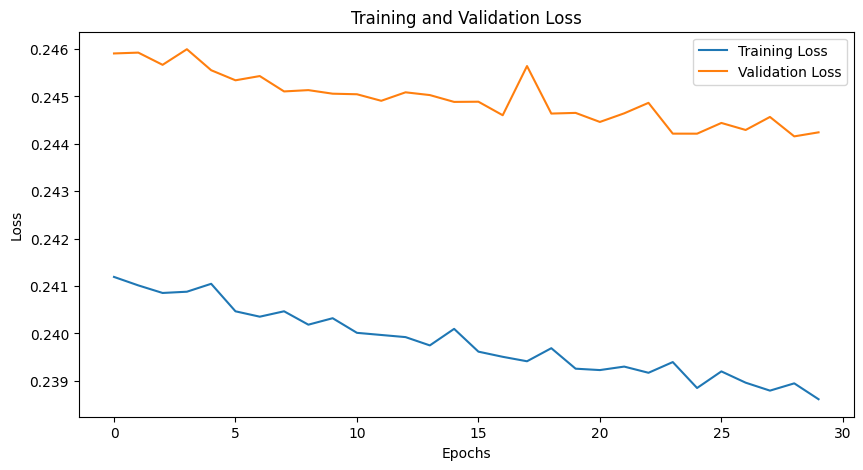

In [38]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Dalam plotting walau Loss menuju kebawah hal ini dapat membuktikan model belum begitu sempurrna dikarenakan jarak yang begitu tidak rapat walau sama sama menurun.

In [40]:
# Evaluate the quality of the reconstructed images using SSIM
ssim_values = [ssim(X_test_filtered[i].reshape(28, 28), decoded_imgs[i].reshape(28, 28), data_range=decoded_imgs[i].max() - decoded_imgs[i].min()) for i in range(len(X_test_filtered))]
average_ssim = np.mean(ssim_values)
print(f"Average SSIM: {average_ssim}")

Average SSIM: 0.88088515774839


Nilai yang didapat hampir menjadi 1, dan hal ini terbilang cukup baik untuk menjadi model.

# Data Predict

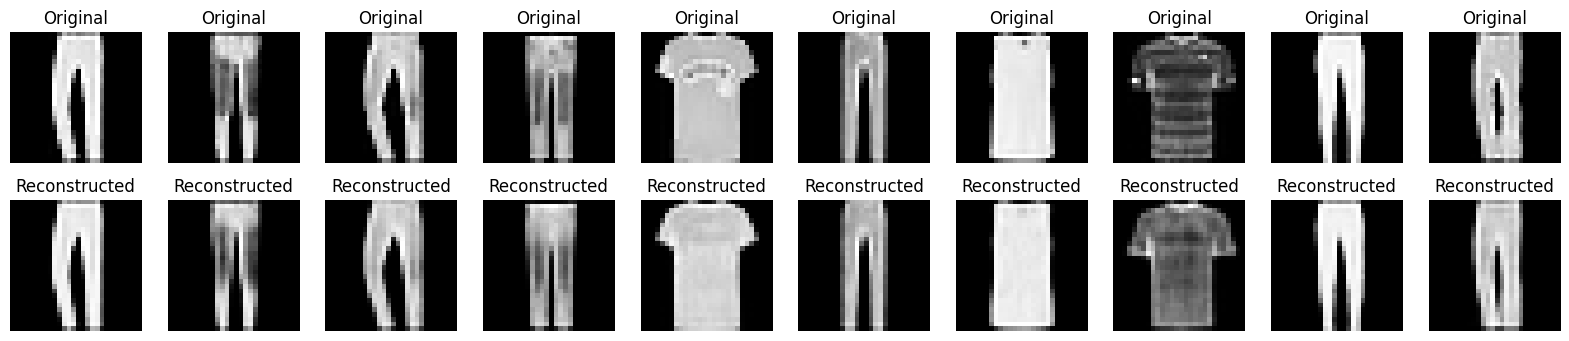

In [41]:
# Visualize some of the original and reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_filtered[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()

# Modified Model

In [45]:
# Encoder modified
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
encoded = Dense(64, activation='relu')(x)

# Decoder modified
x = Dense(128, activation='relu')(encoded)
x = Dense(7 * 7 * 64, activation='relu')(x)
x = Reshape((7, 7, 64))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [46]:
modified_autoencoder = Model(input_img, decoded)
modified_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')

In [47]:
# Train the modified autoencoder
history_modified = modified_autoencoder.fit(X_train_val, X_train_val, epochs=30, batch_size=128, shuffle=True, validation_data=(X_val, X_val))

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.4519 - val_loss: 0.3105
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.2957 - val_loss: 0.2860
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.2784 - val_loss: 0.2729
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.2693 - val_loss: 0.2673
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2616 - val_loss: 0.2635
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.2591 - val_loss: 0.2612
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2582 - val_loss: 0.2614
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2534 - val_loss: 0.2583
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.2568 - val_loss: 0.2583
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.2560 - val_loss: 0.2566
Epoch 11/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2539 - val_loss: 0.2559
Epoch 12/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.2

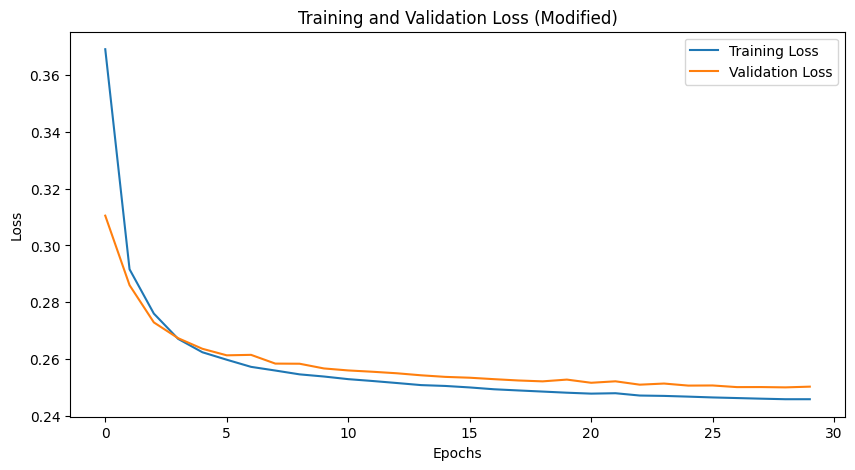

In [50]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_modified.history['loss'], label='Training Loss')
plt.plot(history_modified.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Modified)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Model terbilang cukup baik , karena menunjukan loss yang menurun dalam pelathihan setiap epoch.

# Predict the Modified Model

In [48]:
# Predict on the test data
decoded_imgs_modified = modified_autoencoder.predict(X_test_filtered)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [49]:
# Evaluate the quality of the reconstructed images using SSIM
ssim_values_modified = [ssim(X_test_filtered[i].reshape(28, 28), decoded_imgs_modified[i].reshape(28, 28), data_range=1.0) for i in range(len(X_test_filtered))]
average_ssim_modified = np.mean(ssim_values_modified)
print(f"Average SSIM (Modified): {average_ssim_modified}")

Average SSIM (Modified): 0.8453565389270934


Hasil yang didapatkan lebih kecil dibandingkan dengan baseline, namun tidak begitu signifingkan.

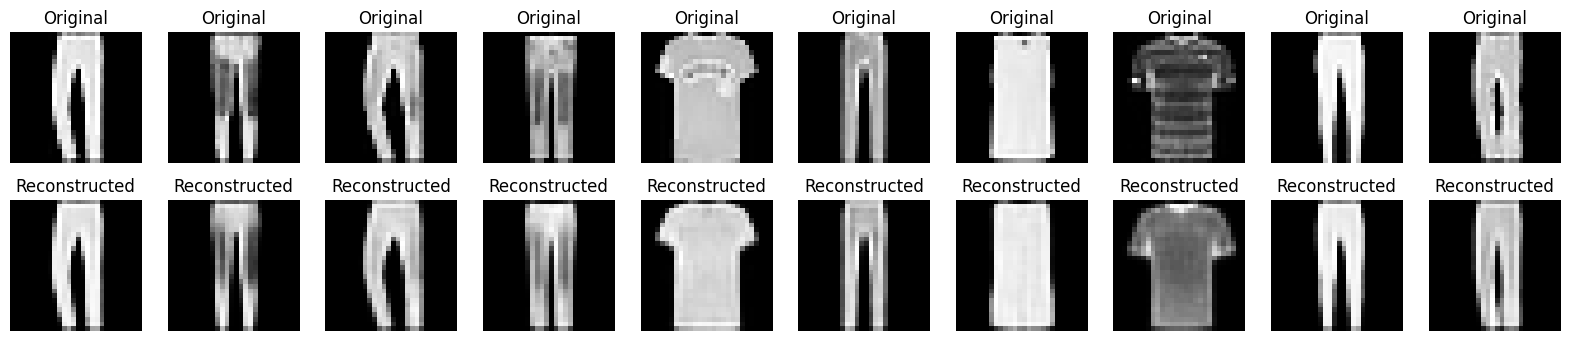

In [51]:
# Visualize some of the original and reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_filtered[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_modified[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()